# Figure 3: Pathway characteristics

In [1]:
import pyam 
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D 
from matplotlib.patches import Patch
from pathlib import Path 
import string 
import numpy as np 
plt.style.use("plotting_template.mplstyle")

<IPython.core.display.Javascript object>

# Read in data 
## Special report on 1.5°C

In [2]:
data_folder = Path("../data")

In [3]:
variables_of_interest = [ 
    "AR5 climate diagnostics|Temperature|Exceedance Probability|1.5 °C|MAGICC6", 
    "AR5 climate diagnostics|Temperature|Exceedance Probability|2.0 °C|MAGICC6", 
    "Emissions|CO2", 
    "Emissions|Kyoto Gases (AR5-GWP100)" , 
    "AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED"   
]

In [4]:
df_sr15 = pyam.IamDataFrame( 
    Path(data_folder / "sr15_downselected.xlsx")
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/sr15_downselected.xlsx
pyam.core - INFO: Reading meta indicators


In [5]:
df_sr15.load_meta( 
    Path(data_folder / "sr15_updated_meta.xlsx")
)

pyam.core - INFO: Reading meta indicators


In [6]:
df_sr15.filter(
    variable = variables_of_interest, 
    inplace = True 
)

## ENGAGE

In [7]:
df_engage = pyam.IamDataFrame( 
    Path(data_folder / "engage_downselected.xlsx")
)

pyam.core - INFO: Reading file ../data/engage_downselected.xlsx
pyam.core - INFO: Reading meta indicators


In [8]:
df_engage.load_meta(
    Path(data_folder / "engage_updated_meta.xlsx")
)

pyam.core - INFO: Reading meta indicators


In [9]:
df_engage.rename(
    variable = {
        "Emissions|Kyoto Gases":"Emissions|Kyoto Gases (AR5-GWP100)", 
        'AR5 climate diagnostics|Temperature|Exceedance Probability|2.0 degC|MAGICC6': 'AR5 climate diagnostics|Temperature|Exceedance Probability|2.0 °C|MAGICC6', 
        'AR5 climate diagnostics|Temperature|Exceedance Probability|1.5 degC|MAGICC6' : 'AR5 climate diagnostics|Temperature|Exceedance Probability|1.5 °C|MAGICC6'
    }, 
    inplace = True
)

In [10]:
df_engage.filter(
    variable = variables_of_interest, 
    inplace = True
)

In [11]:
df_analysis = df_sr15.append(df_engage)

# Assign years of net zero

In [12]:
def _cross_threshold(x):
    y = pyam.cross_threshold(x, threshold=0.1)
    # set threshold slightly above 0 to catch convergence to 0
    return y[0] if len(y) else 2101 #I adapt this to 2101 to catch the >2100 explicitly

def calculate_netzero(_df):
    return _df.apply(_cross_threshold, raw=False, axis=1)

In [13]:
co2 = (
    df_analysis
    .filter(variable = "Emissions|CO2")
    .timeseries()
)

In [14]:
df_analysis.set_meta(
    calculate_netzero(co2),
    "netzero|CO2"
)

In [15]:
kyotoghg = (
    df_analysis
    .filter(variable = "Emissions|Kyoto Gases (AR5-GWP100)")
    .timeseries()
)

In [16]:
df_analysis.set_meta(
    calculate_netzero(kyotoghg),
    "netzero|kyotoghg"
)

# Assign 2030 emission levels

In [17]:
df_analysis.set_meta_from_data(
    name = "Emissions|KyotoGHG|2030", 
    variable = "Emissions|Kyoto Gases (AR5-GWP100)", 
    year = 2030 
)

In [18]:
df_analysis.set_meta_from_data(
    name = "Emissions|CO2|2030", 
    variable = "Emissions|CO2", 
    year = 2030 
)

# Figure 3

In [19]:
plt.rcParams.update({'mathtext.default':  'regular' })

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


Text(0, 0.5, 'Gt $CO_2$e')

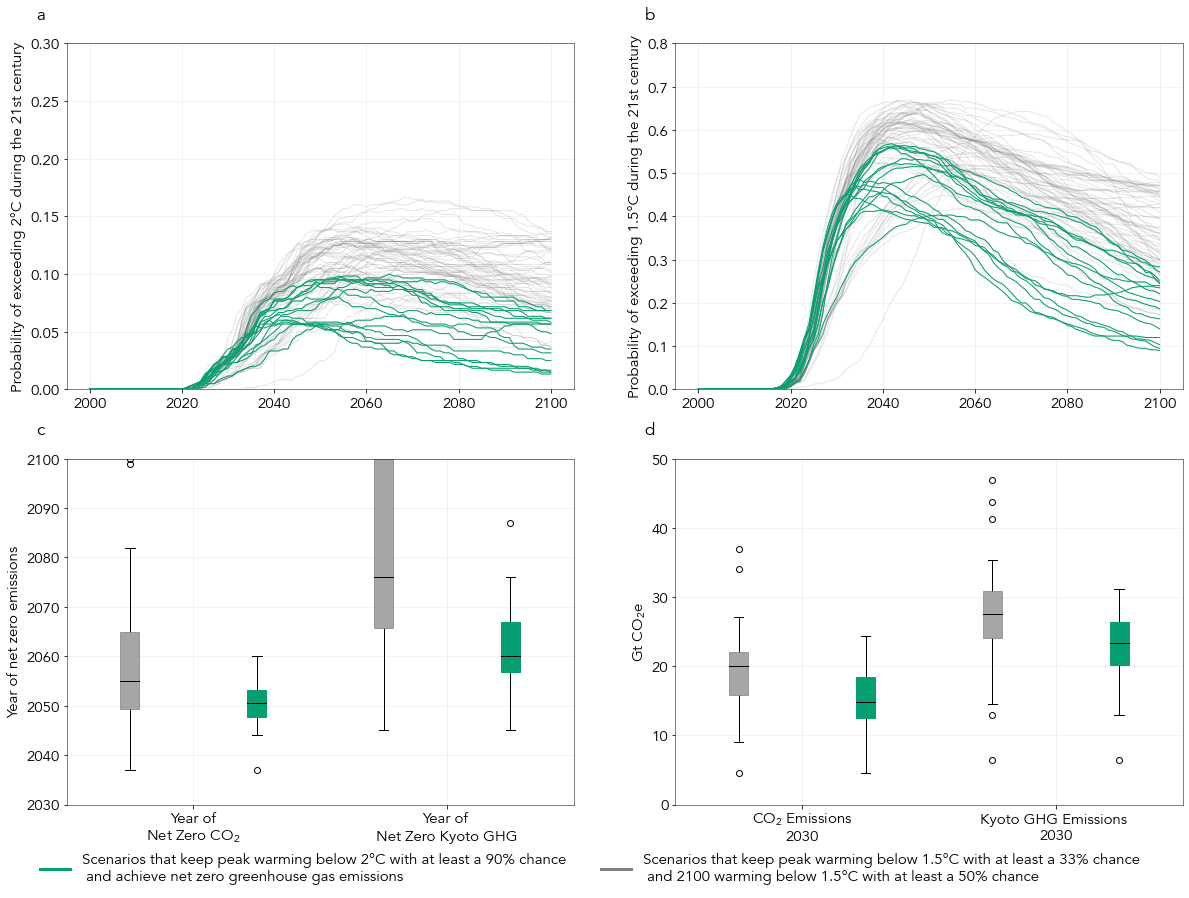

In [20]:
fig, ax = plt.subplots(2,2, figsize = (20,14))
# Panel 1
## Probability of exceeding 2C
df_analysis.filter(
    category = ["Below 1.5C", "1.5C low overshoot"],
    variable = "AR5 climate diagnostics|Temperature|Exceedance Probability|2.0 °C|MAGICC6"
).plot(ax = ax[0,0], color = "grey", alpha=0.2)
df_analysis.filter(
    category_new = "PA (Art 2 and 4)",
    variable = "AR5 climate diagnostics|Temperature|Exceedance Probability|2.0 °C|MAGICC6"
).plot(ax = ax[0,0], color = "#069f72")
ax[0,0].set_title("")
ax[0,0].set_ylim(0,0.3)
ax[0,0].set_ylabel("Probability of exceeding 2°C during the 21st century")

# Panel 2
df_analysis.filter(
    category = ["Below 1.5C", "1.5C low overshoot"],
    variable = "AR5 climate diagnostics|Temperature|Exceedance Probability|1.5 °C|MAGICC6"
).plot(ax = ax[0,1], color = "grey", alpha=0.2)
df_analysis.filter(
    category_new = "PA (Art 2 and 4)",
    variable = "AR5 climate diagnostics|Temperature|Exceedance Probability|1.5 °C|MAGICC6"
).plot(ax = ax[0,1], color = "#069f72")
ax[0,1].set_title("")
ax[0,1].set_ylim(0,0.8)
ax[0,1].set_ylabel("Probability of exceeding 1.5°C during the 21st century")


# Panel 3
## Year of net zero CO2
lo_os = df_analysis.filter(category = ["Below 1.5C", "1.5C low overshoot"]).meta
art2 = df_analysis.filter(category_new = "PA (Art 2 and 4)").meta


p1 = ax[1,0].boxplot(
    lo_os["netzero|CO2"], 
    positions = [0], 
    patch_artist=True
)
p2 = ax[1,0].boxplot(
    art2["netzero|CO2"], 
    positions = [1], 
    patch_artist=True
)

p3 = ax[1,0].boxplot(
    lo_os["netzero|kyotoghg"].dropna(), 
    positions = [2], 
    patch_artist=True
)
p4 = ax[1,0].boxplot(
    art2["netzero|kyotoghg"], 
    positions = [3],
    patch_artist=True
)

# Panel 4
p5 = ax[1,1].boxplot(
    (lo_os["Emissions|CO2|2030"]/1e3).dropna(), 
    positions = [0], 
    patch_artist=True
)
p6 = ax[1,1].boxplot(
    (art2["Emissions|CO2|2030"]/1e3).dropna(), 
    positions = [1],
    patch_artist=True
)

p7 = ax[1,1].boxplot(
    (lo_os["Emissions|KyotoGHG|2030"]/1e3).dropna(), 
    positions = [2], 
    patch_artist=True
)
p8 = ax[1,1].boxplot(
    (art2["Emissions|KyotoGHG|2030"]/1e3).dropna(), 
    positions = [3],
    patch_artist=True
)


for p in [p2, p4, p6, p8]:
    plt.setp(p['boxes'], color="#069f72")
    plt.setp(p['medians'], color='black')  

for p in [p1, p3, p5, p7]:
    plt.setp(p['boxes'], color="grey", alpha=0.7)
    plt.setp(p['medians'], color='black')  

ax[1,0].set_ylim(2030,2100)
ax[1,0].set_xticks([0.5, 2.5])
ax[1,0].set_xticklabels(
    [ 
        "Year of\nNet Zero $CO_2$", 
        "Year of \nNet Zero Kyoto GHG"
    ]
)

ax[1,1].set_ylim(0, 50)
ax[1,1].set_xticks([0.5, 2.5])
ax[1,1].set_xticklabels(
    [ 
        "CO$_2$ Emissions\n2030", 
        "Kyoto GHG Emissions \n2030"
    ]
)

# Annotation
for n,a in enumerate(ax[0]):
    a.text(
        -0.06, 1.07, 
        string.ascii_lowercase[n], 
        transform=a.transAxes,
        size=17, 
        weight='bold'
    )
    a.set_xlabel("")

for n,a in enumerate(ax[1]):
    a.text(
        -0.06, 1.07, 
        string.ascii_lowercase[n+2], 
        transform=a.transAxes,
        size=17, 
        weight='bold'
    )
    a.set_xlabel("")

# Add custom legend 
# Custom legend 
legend_elements = [ 
    Line2D([0], [0], color='#069f72', lw=3, label = "Scenarios that keep peak warming below 2°C with at least a 90% chance \n and achieve net zero greenhouse gas emissions"), 
    Line2D([0], [0], color='grey',lw = 3, label = "Scenarios that keep peak warming below 1.5°C with at least a 33% chance \n and 2100 warming below 1.5°C with at least a 50% chance")
]

ax[1,0].legend(handles=legend_elements, bbox_to_anchor = (2.15, -0.1), ncol=2)
ax[1,0].set_ylabel("Year of net zero emissions")
ax[1,1].set_ylabel("Gt $CO_2$e")

In [21]:
fig.savefig(
    Path("figures/Figure 2.png")
)

# Statistics for text

In [22]:
cols_to_summarise = [
    "netzero|kyotoghg", 
    "netzero|CO2",
    "Emissions|CO2|2030",
    "Emissions|KyotoGHG|2030",
]

In [23]:
analysis_data = df_analysis.filter(
    netzero=True
).meta

In [24]:
analysis_data.groupby(
    "category"
)[cols_to_summarise].describe().to_excel("tables/Table_for_Fig3.xlsx")

# [New] Figure 2

## Panel 1: Peak exceedance probabilities

In [25]:
df_analysis.set_meta_from_data(
    variable = "AR5 climate diagnostics|Temperature|Exceedance Probability|2.0 °C|MAGICC6", 
    name = "peak_exceedance_2p0", 
    method = np.max
)

In [26]:
df_analysis.set_meta_from_data(
    variable = "AR5 climate diagnostics|Temperature|Exceedance Probability|1.5 °C|MAGICC6", 
    name = "peak_exceedance_1p5", 
    method = np.max
)

In [27]:
panel_1_variables = [ 
    "peak_exceedance_2p0", 
    "peak_exceedance_1p5"
]

In [28]:
panel_1_net_zero = (
    df_analysis
    .filter(
        netzero=True, 
        category = ["Below 1.5C", "1.5C*", "Lower 2C"]
    )
    .meta[panel_1_variables]
)
panel_1_no_net_zero = (
    df_analysis
    .filter(
        netzero=False, 
        category = ["Below 1.5C", "1.5C*", "Lower 2C"]    
    )
    .meta[panel_1_variables]
)

## Panel 2: Total absolute temperature decline

In [29]:
# Assign peak and end of century warming 
df_analysis.set_meta_from_data(
    name = "peak_warming",
    variable = "AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED", 
    method = np.max
)
df_analysis.set_meta_from_data(
    name = "2100_warming",
    variable = "AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED", 
    year = 2100
)

In [30]:
df_analysis.set_meta(
    df_analysis.meta.apply(
        lambda x: x["2100_warming"] -  x["peak_warming"], 
        axis = 1
    ), 
    name = "difference_peak_and_decline"
)

In [31]:
# Identify year of peak warming 
def peak_warming(x):
    peak = x[x == x.max()]
    return peak.index[0]

In [32]:
temp = df_analysis.filter(variable ="AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED").timeseries()
df_analysis.set_meta(
    temp.apply(peak_warming, axis=1), 
    name = "year_of_peak_warming"
)

In [33]:
# Normalise in a per decade manner
df_analysis.set_meta(
    df_analysis.meta.apply(
        lambda x: x["difference_peak_and_decline"] / (2100 - x["year_of_peak_warming"]) if (x["year_of_peak_warming"] < 2100) else 0, 
        axis=1
    ), 
    name = "peak_and_decline_per_year"
)

In [34]:
df_analysis.set_meta(
    df_analysis.meta.apply(
        lambda x: x["peak_and_decline_per_year"] * 10, 
        axis=1
    ), 
    name = "peak_and_decline_per_decade"
)

In [35]:
panel_2_variables = [ 
    "difference_peak_and_decline", 
    "peak_and_decline_per_decade"
]

In [36]:
panel_2_net_zero = (
    df_analysis
    .filter(
        netzero=True, 
        category = ["Below 1.5C", "1.5C*", "Lower 2C"]
    )
    .meta[panel_2_variables]
)
panel_2_no_net_zero = (
    df_analysis
    .filter(
        netzero=False, 
        category = ["Below 1.5C", "1.5C*", "Lower 2C"]    
    )
    .meta[panel_2_variables]
)

In [37]:
fig, ax = plt.subplots(1,3, figsize=(22,7))

# Panel 1 
for i, var in enumerate(panel_1_variables):
    p1 = ax[0].boxplot(
        panel_1_net_zero[var], 
        positions = [i], 
        patch_artist = True
    )
    p2 = ax[0].boxplot(
        panel_1_no_net_zero[var], 
        positions = [i+0.5], 
        patch_artist=True
    )
    plt.setp(p1['boxes'], color="#cc79a7")
    plt.setp(p1['medians'], color="black")
    plt.setp(p2['boxes'], color="#d35f27")
    plt.setp(p2['medians'], color="black")

ax[0].set_xticks([0.25, 1.25])
ax[0].set_xticklabels(
    [
        "1.5°C",
        "2°C"
    ]
)
ax[0].set_ylabel("Peak exceedance probability [0-1]")
ax[0].set_ylim(0,1)

# Panel 2
for i, var in enumerate(panel_2_variables):
    p1 = ax[i+1].boxplot(
        panel_2_net_zero[var], 
        positions = [i], 
        patch_artist = True
    )
    p2 = ax[i+1].boxplot(
        panel_2_no_net_zero[var], 
        positions = [i+0.5], 
        patch_artist=True
    )
    plt.setp(p1['boxes'], color="#cc79a7")
    plt.setp(p1['medians'], color="black")
    plt.setp(p2['boxes'], color="#d35f27")
    plt.setp(p2['medians'], color="black")

ax[1].set_xticks([0.25])
ax[1].set_xticklabels(["Difference Between \nPeak and End of Century Warming"])
ax[1].set_ylabel("°C")
ax[1].set_ylim(-0.6, 0.01,)

ax[2].set_xticks([1.25])
ax[2].set_xticklabels(["Post-Peak \nTemperature Trend"])
ax[2].set_ylabel("°C / decade")
ax[2].set_ylim(-0.11, 0.01)

n_net_zero = len(panel_2_net_zero[var])
n_no_net_zero = len(panel_2_no_net_zero[var])

# Legend
legend_handles = [ 
    Patch(facecolor="#cc79a7", label = "Scenarios that achieve net zero greenhouse gas emissions [N={}]".format(n_net_zero)), 
    Patch(facecolor="#d35f27", label = "Scenarios that do not achieve net zero greenhouse gas emissions [N={}]".format(n_no_net_zero))
]
ax[1].legend(handles = legend_handles, bbox_to_anchor= (1.85, -0.1), ncol=2)


# Annotations
for n,a in enumerate(ax):
    a.text(
        -0.06, 1.07, 
        string.ascii_lowercase[n], 
        transform=a.transAxes,
        size=17, 
        weight='bold'
    )
    a.set_xlabel("")

In [38]:
fig.savefig(
    Path("figures/Figure 3.png")
)